In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image as Image

from tensorflow.keras import layers


In [34]:

# Carica la rete preallenata:
# 1) è inception V3
# 2) come dataset di training hanno usato imagenet
# 3) è l'intera rete per fare la classificazione, per il riaddestramento c'è 
#    "feature_vector"
classifier_url ="https://tfhub.dev/google/imagenet/inception_v3/classification/4" #@param {type:"string"}

IMAGE_SHAPE = (250, 250)

In [16]:

# Costruisce il classificatore su keras; in questo caso non la sto riaddestrando
# quindi ho preso l'intera rete (Compresa di class-layer) e la sto usando tutta
# in una Sequential

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

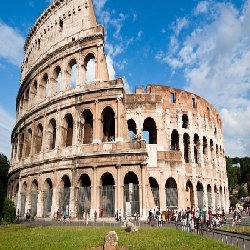

In [27]:

# Apro immagine a caso

img = Image.open('./resources/images_test.jpg').resize(IMAGE_SHAPE)
img

In [28]:

# Reshaping

img = np.array(img)/255.0
img.shape

(250, 250, 3)

In [29]:

# Qui fa inferenza e trova il risultato di classificazione. In questo caso
# ImageNet ha 1001 classi, quindi restituisce un vettore con 1001 numeri i
# cui valori indicano quanto è confidente per ogni classe.

result = classifier.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [30]:

# Prende la classe con la massima confidenza

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

669

In [31]:

# Carica online tutte le classi di imagenet, così da capire quale ha scelto

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


16384/10484 [==============================================] - 0s 0us/step


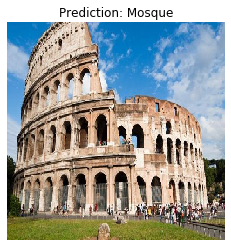

In [33]:

# Mostra l'immagine e la classificazione finale

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:



# TODO Manca tutta la parte di caricamento delle immagini e di test sul data-set, mi sono accorto che non ho il dataset scaricato sul pc quindi non lo posso testare.

# c'erano dei problemi anche sul caricamento dei moduli (sono dentro la cartella models e gli import erano tutti non espliciti)


from models import codebase as cb

# Load the dataframes from dataset files (min_size default is [250, 250])
pict_df, arch_df = cb.load_data(max_size=[250, 250])

# Image -> picture/architecture
art_or_building = cb.get_art_or_building(pict_df, arch_df)
# Image -> picture_style (136 total styles)
whats_style_pict = cb.get_whats_style(pict_df)
# Image -> architecture_style (25 styles total)
whats_style_arch = cb.get_whats_style(arch_df)









In [ ]:

# Carica inception V3 ma senza l'ultimo layer di classificazione, e setta trainable=false per fare poi la backprop solo sull'ultimo layer

# TODO Per funzionare necessita di image_data, con dentro num_classes (numero di classi), class_indices (con tutti gli indici di classificazione), samples (numero di elementi), batch_size.

feature_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"

model = tf.keras.Sequential([
    hub.KerasLayer(feature_url,
                   trainable=False,
                   input_shape=(250, 250, 3)),
    tf.keras.layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:

# Fit: addestra la rete, su 2 epoche (veloce)

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

In [ ]:

# Plotta loss

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:

# Estrae i nomi delle classi

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

In [ ]:
# Run the image batch through the model and convert the indices to class names.
# TODO Questo richiede di costruire image_batch, che contiene una serie di immagini su cui fare inferenza

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

# Plot the result

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:

# TODO Manca la parte di CV